In [2]:
import glob; import sys; import os
import pandas as pd
import functions
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode
from matplotlib.lines import Line2D
from matplotlib.legend import Legend

pd.options.mode.chained_assignment = None
plt.rcParams.update({'font.size': 20}) # Set a good font size

# Defining constants
G = 1.908e5 # R_sol*(M_sol)^-1*km^2*s^-2 
pc2AU = 206265 # Pc -> AU
Rsol2AU = 0.00465047 # Rsol -> AU
pcMyr2kms = 1.023 # Pc/Myr -> km/s

In [26]:
dataDict = functions.get_Started(Comparing=True)

Possible Directories:

0 : COMPAS_Output_1%sol_fallback
1 : COMPAS_Output_1%sol_noKicks
2 : COMPAS_Output_1%sol_reduced
3 : COMPAS_Output_1%_correctedEVO
4 : COMPAS_Output_1%_no_CHE
5 : COMPAS_Output_1%_pessCHE
6 : COMPAS_Output_largea_detailed
7 : COMPAS_Output_largea_detailed2
8 : COMPAS_Output_noBHKick_Z0.0001
9 : COMPAS_Output_noBHKick_Z0.001
10 : COMPAS_Output_noChem
11 : COMPAS_Output_PeTar_M100000
12 : COMPAS_Output_smalla_detailed
13 : COMPAS_Output_smalla_detailed2
14 : COMPAS_Output_sol_correctEVO
15 : COMPAS_Output_sol_no_CHE
16 : COMPAS_Output_SSE_Z0.00015
17 : COMPAS_Output_SSE_Z0.0015
18 : COMPAS_Output_test
19 : COMPAS_Output_test2
20 : COMPAS_Output_Z0.0001
21 : COMPAS_Output_Z0.00015
22 : COMPAS_Output_Z0.0005
23 : COMPAS_Output_Z0.00075
24 : COMPAS_Output_Z0.001
25 : COMPAS_Output_Z0.0015
26 : COMPAS_Output_Z0.005
27 : COMPAS_Output_Z0.0075
28 : COMPAS_Output_Z0.01
29 : COMPAS_Output_Z0.01_varied



What directory is the data stored in?    20,24,28



Currently selected datasets:
dict_keys(['Z0.0001', 'Z0.001', 'Z0.01'])


Are these all of the datasets to compare?[y/n] y


In [34]:
# Define constants of the system
k=2

vesc_array = np.logspace(1,np.log10(2e3),10) # km/s

data = {}

for key, item in dataDict.items():
    # Load in the double compact objects as well as the system parameters
    DCO = pd.read_csv(os.path.join(item, 'BSE_Double_Compact_Objects.csv'), skiprows=2)
    SP = pd.read_csv(os.path.join(item, 'BSE_System_Parameters.csv'), skiprows=2)
    SN = pd.read_csv(os.path.join(item, 'BSE_Supernovae.csv'), skiprows=2)


    # Find the equilibrated at birth and remove them from the DCOs
    EAB = SP.loc[SP['Equilibrated_At_Birth']==1] 
    DCO.drop(DCO.loc[DCO['    SEED    '].isin(EAB['    SEED    '])].index, inplace=True)
    SN.drop(SN.loc[SN['    SEED    '].isin(EAB['    SEED    '])].index, inplace=True)


    # Specifically grab the BBHs
    BBHMaster = DCO.loc[(DCO['Stellar_Type(1)']==14)&(DCO['Stellar_Type(2)']==14)].copy()
    BBHMaster.reset_index(inplace=True, drop=True)


    # For now I am dropping any binaries with a>1e6
    BBHMaster = BBHMaster.loc[BBHMaster['SemiMajorAxis@DCO']<1e6]
    
    '''
    Here we find all of the possible BH systems so that we can 
    later find which have been retained.
    '''

    # Index for both SNs , only first and only last
    SNDupIndex = SN.duplicated(subset='    SEED    ', keep=False)

    SN1st = SN.loc[SN.duplicated(subset='    SEED    ', keep='last')]
    SN2nd = SN.loc[SN.duplicated(subset='    SEED    ', keep='first')]

    SN1st.reset_index(drop=True, inplace=True)
    SN2nd.reset_index(drop=True, inplace=True)

    # Two SNs
    SNDup = SN.loc[SNDupIndex]
    SNDup.reset_index(inplace=True, drop=True)

    # Single SN
    SNSing = SN.loc[~SNDupIndex]
    SNSing.reset_index(inplace=True, drop=True)

    # BH other star unbound and bound
    BHSingUnbound = SNSing.loc[(SNSing['Stellar_Type(SN)']==14)&(SNSing['Unbound']==1)]
    BHSingBound = SNSing.loc[(SNSing['Stellar_Type(SN)']==14)&(SNSing['Unbound']==0)]

    BHSingUnbound.reset_index(inplace=True, drop=True)
    BHSingBound.reset_index(inplace=True, drop=True)

    # BBHs that remain bound
    BBHBound = SN.loc[(SN['Stellar_Type(SN)']==14)&(SN['Stellar_Type(CP)']==14)&(SN['Unbound']==0)]
    BBHBound.reset_index(inplace=True, drop=True)

    # BH other SN
    BHElse = SN2nd.loc[((SN2nd['Stellar_Type(SN)']==14)&(SN2nd['Stellar_Type(CP)']!=14))|((SN2nd['Stellar_Type(CP)']==14)&(SN2nd['Stellar_Type(SN)']!=14))]
    BHElse.reset_index(drop=True, inplace=True)

    # BBHs that are not bound
    BBHUnbound = SN.loc[(SN['Stellar_Type(SN)']==14)&(SN['Stellar_Type(CP)']==14)&(SN['Unbound']==1)]
    BBHUnbound.reset_index(inplace=True, drop=True)

    
    # Finding the average BH mass
    avgBHMass = np.mean(SN['   Mass(SN)   '].loc[SN['Stellar_Type(SN)']==14].values)  
        
    # For equipartition of energy eta=1 --- for initial equilibrium eta = avgBHMass/1
    eta=avgBHMass/1
#     eta=1
    # Empty arrays to store
    intRatioTot=[]
    
    for vesc in vesc_array:
        # Cluster velocity dispersion
        sigmaCL = vesc/(np.sqrt(14*(1+eta/avgBHMass))) # km/s
        sigmaREL = np.sqrt((2*eta)/avgBHMass) * sigmaCL

        # seeds retained from first SN
        retainedInFirst = SN1st.loc[(SN1st['SystemicSpeed ']<vesc)&(SN1st['Unbound']==0)]
        retainedSN = SN1st.loc[(SN1st['ComponentSpeed(SN)']<vesc)&(SN1st['Unbound']==1)]
        retainedCP = SN1st.loc[(SN1st['ComponentSpeed(CP)']<vesc)&(SN1st['Unbound']==1)]

        # BBHbound retained after second
        index = BBHBound['    SEED    '].isin(retainedInFirst['    SEED    '])
        BBHRetain = BBHBound.loc[(BBHBound['SystemicSpeed ']<vesc)&(index)]


        # Check if there are any duplicates
        if len(BBHRetain)!=len(np.unique(BBHRetain['    SEED    '].values)):
            BBHRetain.drop_duplicates(subset='    SEED    ', inplace=True, keep='last')

        BBHRetain.reset_index(inplace=True, drop=True)    
        '''
        Finding hard binaries
        '''
        # Reduced Mass
        mu  = BBHRetain['   Mass(SN)   ']*BBHRetain['   Mass(CP)   ']/(BBHRetain['   Mass(SN)   ']+BBHRetain['   Mass(CP)   '])

        # calculate hard boundary
        ah  = (G * mu)/sigmaREL**2 # Rsol

        BBHRetain['ah'] = ah

        # Define the hard index
        hard = BBHRetain['SemiMajorAxis '] < BBHRetain['ah']

        # Define binary total mass
        Mtot = BBHRetain['   Mass(SN)   '] + BBHRetain['   Mass(CP)   ']
        BBHRetain['Mtot'] = Mtot

        # Only take hard binaries
        BBHRetainHard = BBHRetain.loc[hard]
        BBHRetainHard.reset_index(inplace=True, drop=True)

        '''
        Finding all of the retained singles (we only need to know the masses)
        '''
        singlesMass = np.array([])

        # BBHUnbound on second
        index = BBHUnbound['    SEED    '].isin(retainedInFirst['    SEED    '])

        singlesMass = np.append(singlesMass, BBHUnbound['   Mass(SN)   '].loc[(index)&(BBHUnbound['ComponentSpeed(SN)']<vesc)].values)
        singlesMass = np.append(singlesMass, BBHUnbound['   Mass(CP)   '].loc[(index)&(BBHUnbound['ComponentSpeed(CP)']<vesc)].values)
        singlesMass = np.append(singlesMass, retainedSN['   Mass(SN)   '].loc[retainedSN['Stellar_Type(SN)']==14].values)

        index = SN2nd['    SEED    '].isin(retainedCP['    SEED    '])
        singlesMass = np.append(singlesMass, SN2nd['   Mass(SN)   '].loc[(index)&(SN2nd['ComponentSpeed(SN)']<vesc)&(SN2nd['Stellar_Type(SN)']==14)].values)

        # averages of the masses
        singleMassMu = np.mean(singlesMass)
        BBHMassMu = np.mean(BBHRetain['   Mass(CP)   '].values+BBHRetain['   Mass(SN)   '].values)



        '''
        Find the total interaction of every binary with every other binary
        '''

        gammaB=0
        gammaS=0
        count=0
        if BBHRetainHard.empty:
            intRatioTot.append(0)
            print('No more hard binaries')
            continue
        
        for ind in BBHRetainHard.index:
            targ = BBHRetainHard.loc[ind]

            # Define projectile binaries
            index = BBHRetain.loc[BBHRetain['    SEED    '].values==targ['    SEED    ']].index
            proj = BBHRetain.drop(index)

            sigmaRelSingle = sigmaCL * np.sqrt((eta/avgBHMass)*(1 + singleMassMu/targ['Mtot']))
            # Relative vel disp for BBH projectiles
            sigmaRelBBH = sigmaCL * np.sqrt((eta/avgBHMass)*(1 + BBHMassMu/targ['Mtot']))

            # Interaction of target binary with singles
            gammaS += np.sum(targ['SemiMajorAxis ']**2 * sigmaRelSingle * (1 + (G*(targ['Mtot']+singlesMass))/(k*targ['SemiMajorAxis ']*sigmaRelSingle**2)))

            # Interaction of target binary with other binaries
            gammaB += np.sum((targ['SemiMajorAxis '] + proj['SemiMajorAxis '].values)**2 * sigmaRelBBH * (1 + (G*(targ['Mtot']+proj['Mtot'].values))/(k*(targ['SemiMajorAxis '] + proj['SemiMajorAxis '].values)*sigmaRelBBH**2)))
            
            count+=1
            print(f'{count/len(BBHRetainHard):.0%} Completed', end='\r')

        # Calculate the interaction rate for this binary
        intRatioTot.append(gammaB/gammaS)
        print(f'Vesc = {vesc:.3g} completed', end='\r\n')
        
    # Final interaction ratio
    intRatioTot = np.asarray(intRatioTot)
    data[key] = intRatioTot
    
    print(f'Data for {key} grabbed')
    
   

Vesc = 10 completed
Vesc = 18 completed
Vesc = 32.5 completed
Vesc = 58.5 completed
Vesc = 105 completed
Vesc = 190 completed
Vesc = 342 completed
Vesc = 616 completed
Vesc = 1.11e+03 completed
Vesc = 2e+03 completed
Data for Z0.0001 grabbed
Vesc = 10 completed
Vesc = 18 completed
Vesc = 32.5 completed
Vesc = 58.5 completed
Vesc = 105 completed
Vesc = 190 completed
Vesc = 342 completed
Vesc = 616 completed
Vesc = 1.11e+03 completed
Vesc = 2e+03 completed
Data for Z0.001 grabbed
Vesc = 10 completed
Vesc = 18 completed
Vesc = 32.5 completed
Vesc = 58.5 completed
Vesc = 105 completed
Vesc = 190 completed
Vesc = 342 completed
Vesc = 616 completed
Vesc = 1.11e+03 completed
No more hard binaries
Data for Z0.01 grabbed


In [31]:
# Saving the equipartition energy 
# dataEqui = data

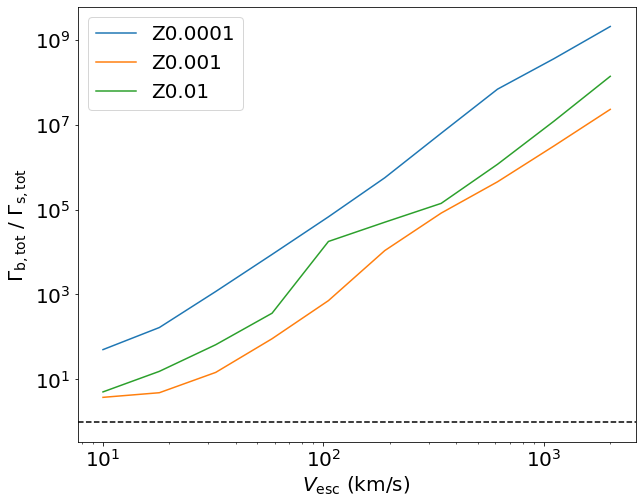

In [33]:
fig, ax = plt.subplots(figsize=(10, 8))

for key, item in data.items():
    ax.plot(vesc_array, item, label=key)


ax.axhline(1, 0, 1, color='black', linestyle='--')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('$V_{\mathrm{esc}}$ (km/s)')
ax.set_ylabel('$\Gamma_{\mathrm{b, tot}}$ / $\Gamma_{\mathrm{s, tot}}$')
ax.legend()

Text(0, 0.5, '$\\Gamma_{\\mathrm{B, tot}}$ / $\\Gamma_{\\mathrm{S, tot}}$')

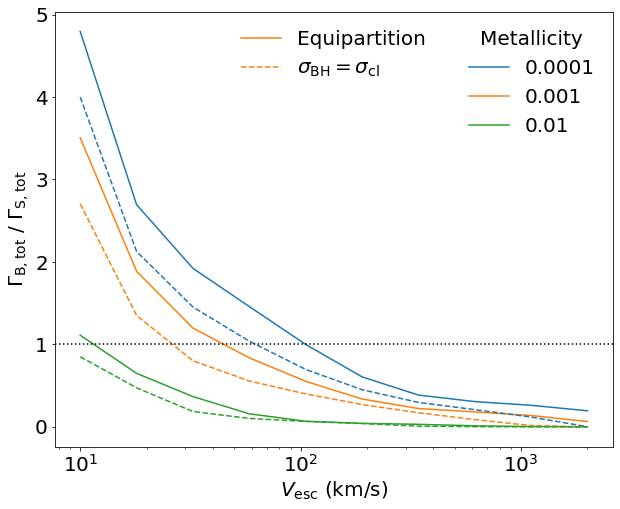

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))


for key, item in dataEqui.items():
    ax.plot(vesc_array, item, label=key.split('Z')[-1])

plt.gca().set_prop_cycle(None)


for key, item in data.items():
    ax.plot(vesc_array, item, linestyle='--')

# Making legends
handles = [Line2D([0,0], [0,0], color='tab:orange'),
           Line2D([0,0], [0,0], color='tab:orange', linestyle='--')]
leg = Legend(ax, handles, loc='upper center', labels=['Equipartition', '$\sigma_{\mathrm{BH}}=\sigma_{\mathrm{cl}}$'], frameon=False)
ax.add_artist(leg)

ax.legend(frameon=False, title='Metallicity')

ax.axhline(1, 0, 1, color='black', linestyle=':')

ax.set_xscale('log')
ax.set_xlabel('$V_{\mathrm{esc}}$ (km/s)')
ax.set_ylabel('$\Gamma_{\mathrm{B, tot}}$ / $\Gamma_{\mathrm{S, tot}}$')


In [15]:
fig.savefig('TotalInteractionOverVesc.pdf', dpi=100)